In [97]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy import interp
from itertools import cycle
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [98]:
df_train = pd.read_csv('https://github.com/ShinyQ/Tugas-Besar-Pembelajaran-Mesin_Classification/blob/main/Dataset/kendaraan_train_clean.csv?raw=true')
df_train.head()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,0.0,0.153846,1.0,0.634615,1.0,0.0,0.0,0.047251,0.932099,0.301038,0
1,1.0,0.430769,1.0,0.750000,0.0,2.0,1.0,0.043104,0.172840,0.512111,0
2,1.0,0.015385,1.0,0.884615,1.0,0.0,0.0,0.056002,0.981481,0.377163,0
3,0.0,0.584615,1.0,0.923077,0.0,1.0,0.0,0.000000,0.759259,0.183391,0
4,1.0,0.461538,1.0,0.673077,0.0,2.0,1.0,0.059953,0.537037,0.636678,0


In [99]:
def transform_data(df):
	X = df.drop('Tertarik', axis=1)
	y = df['Tertarik']

	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
	return X_train, X_test, y_train, y_test
 

def define_model():
		metrics = [
			keras.metrics.BinaryAccuracy(name='accuracy'),
			keras.metrics.Precision(name='precision'),
			keras.metrics.Recall(name='recall'),
			keras.metrics.AUC(name='roc_auc'),
			keras.metrics.AUC(name='prc', curve='PR'),
		]

		model = Sequential()
		model.add(Dense(64, activation="relu"))
		model.add(Dense(32, activation="relu"))
		model.add(Dropout(0.5)),
		model.add(Dense(1, activation='sigmoid'))

		model.compile(
			optimizer=keras.optimizers.Adam(learning_rate=1e-3),
			loss=BinaryCrossentropy(),
			metrics=metrics
		)

		return model


def calculate_class_weight(df):
	total = len(df)

	neg = len(df[df['Tertarik'] == 0])
	pos = len(df[df['Tertarik'] == 1])

	weight_for_0 = (1 / neg) * (total / 2.0)
	weight_for_1 = (1 / pos) * (total / 2.0)
	weights = {0: weight_for_0, 1: weight_for_1}

	return weights


EarlyStop = EarlyStopping(
    monitor='val_roc_auc',
    patience=6,
    mode='max',
    restore_best_weights=True,
	  verbose=0
)

### **Melatih Model Deep Learning** 

In [100]:
model = define_model()
trainX, testX, trainY, testY = transform_data(df_train)

history = model.fit(
    trainX, trainY,
    epochs=100,
    class_weight=calculate_class_weight(df_train),
    verbose=1,
    callbacks=EarlyStop,
    batch_size=256,
    validation_data=(testX, testY)
)

Epoch 1/100
893/893 [==============================] - 6s 5ms/step - loss: 0.4652 - accuracy: 0.6559 - precision: 0.2534 - recall: 0.9352 - roc_auc: 0.8196 - prc: 0.2935 - val_loss: 0.4806 - val_accuracy: 0.6457 - val_precision: 0.2564 - val_recall: 0.9715 - val_roc_auc: 0.8396 - val_prc: 0.3242
Epoch 2/100
893/893 [==============================] - 4s 4ms/step - loss: 0.4468 - accuracy: 0.6669 - precision: 0.2610 - recall: 0.9444 - roc_auc: 0.8306 - prc: 0.3057 - val_loss: 0.4399 - val_accuracy: 0.7031 - val_precision: 0.2846 - val_recall: 0.9145 - val_roc_auc: 0.8419 - val_prc: 0.3284
Epoch 3/100
893/893 [==============================] - 3s 4ms/step - loss: 0.4434 - accuracy: 0.6748 - precision: 0.2651 - recall: 0.9391 - roc_auc: 0.8338 - prc: 0.3111 - val_loss: 0.4675 - val_accuracy: 0.6752 - val_precision: 0.2704 - val_recall: 0.9470 - val_roc_auc: 0.8427 - val_prc: 0.3312
Epoch 4/100
893/893 [==============================] - 3s 4ms/step - loss: 0.4415 - accuracy: 0.6780 - precis

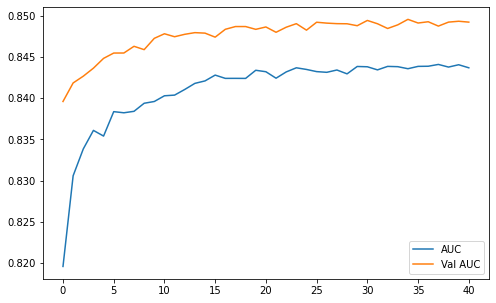

In [101]:
plt.figure(figsize=(8, 5))
plt.plot('roc_auc', data=history.history, label='AUC')
plt.plot('val_roc_auc', data=history.history, label='Val AUC')
plt.legend(loc='lower right')
plt.show()

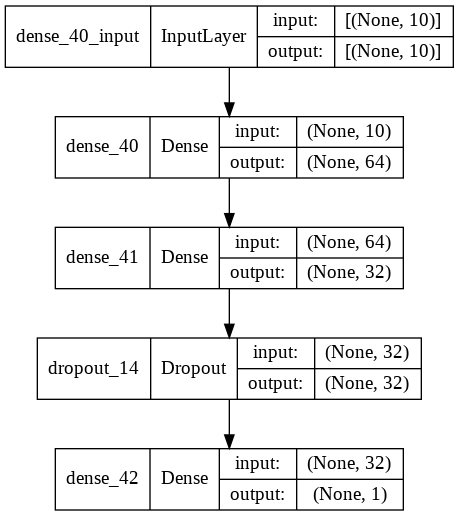

In [102]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### **Evaluasi Model**

In [108]:
def plot_cm(labels, predictions_pure, p=0.5):

    predictions = model.predict(predictions_pure)
    cm = confusion_matrix(labels, predictions > p)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    sns.heatmap(cm, annot=True, xticklabels=[0, 1], yticklabels=[0, 1], cmap='flare', fmt='d', ax=axes[0])
    axes[0].set_title('Confusion Matrix DL, P>0.5')

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    lw = 2
    n_classes = 2
    axes[0].set_title(f'Confusion Matrix DL, P={p}')
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels, predictions)
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr[0], tpr[0], _ = roc_curve(labels, predictions > p)
    roc_auc[0] = auc(fpr[0], tpr[0])


    fpr["micro"], tpr["micro"], _ = roc_curve(labels, predictions)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="best")
    plt.show()

    return predictions


### **Prediksi Dan Evaluasi Data Test**

In [109]:
df = pd.read_csv('https://github.com/ShinyQ/Tugas-Besar-Pembelajaran-Mesin_Classification/blob/main/Dataset/kendaraan_test_clean.csv?raw=true')
df.head()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,0,0.446154,1,0.153846,0,1,1,0.082475,0.154321,0.467128,0
1,1,0.030769,1,0.903846,1,0,0,0.068822,0.932099,0.799308,0
2,1,0.061538,1,0.538462,1,0,0,0.200636,0.932099,0.179931,0
3,1,0.400000,1,0.153846,1,1,0,0.062575,0.759259,0.083045,0
4,1,0.230769,1,0.442308,0,1,1,0.045268,0.932099,0.757785,0


In [110]:
trainy = df.drop('Tertarik', axis=1)
testy = df['Tertarik']

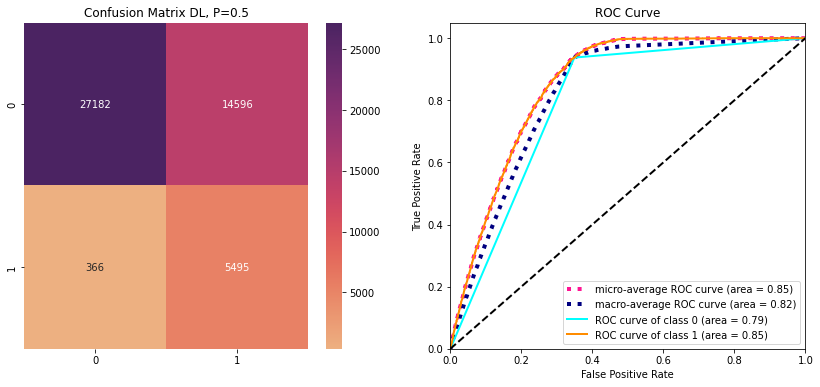


loss :  0.465
accuracy :  0.686
precision :  0.274
recall :  0.938
roc_auc :  0.85
prc :  0.352
f1-score : 0.604


In [111]:
predictions = plot_cm(testy, trainy)
print("")

baseline_test_results = model.evaluate(trainy, testy, verbose=0)
for name, value in zip(model.metrics_names, baseline_test_results):
  print(name, ': ', round(value, 3))

print('f1-score :', round(f1_score(testy, predictions > 0.5, average='macro'), 3))
